In [1]:
from io import open
import glob
import os
import pandas as pd

In [2]:
dataset1 = pd.read_excel("data/names/Bitonto.xlsx", sheet_name="Sheet1")
bitonto = [surname.lower() for surname in dataset1['cognome'].tolist()]
dataset2 = pd.read_excel("data/names/Firenze.xlsx", sheet_name="Sheet1")
firenze =[dataset2['cognome'][k].lower() for k in range(734)]
print(len(bitonto), len(firenze))

734 734


In [3]:
def findFiles(path): 
    return glob.glob(path)

In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

57


In [5]:
category_lines = {}
all_categories = []

In [6]:
def readLines(filename, n_surnames):
    surnametable = pd.read_excel(filename, sheet_name="Sheet1")
    return [surnametable['cognome'][k].lower() for k in range(n_surnames)]

for filename in findFiles('data/names/*.xlsx'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    #print(filename)
    lines = readLines(filename,734)
    category_lines[category] = lines

n_categories = len(all_categories)

In [7]:
import torch

In [8]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for letter_index, letter in enumerate(line):
        tensor[letter_index][0][letterToIndex(letter)] = 1
    return tensor

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [11]:
n_hidden =  128
rnn = RNN(n_letters, n_hidden, n_categories)

In [19]:
input = lineToTensor('marconi')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[1], hidden)

print(input)
print(output)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Bitonto', 1)


In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Firenze / line = ducci
category = Firenze / line = masini
category = Bitonto / line = de biase
category = Bitonto / line = cannito
category = Firenze / line = carrai
category = Bitonto / line = stolfi
category = Bitonto / line = bernardi
category = Bitonto / line = tarantino
category = Bitonto / line = cannone
category = Bitonto / line = decaro


In [21]:
criterion = nn.NLLLoss()

In [23]:
learning_rate = 0.0005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1200



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 0.4531 righini / Firenze ✓
10000 10% (0m 6s) 0.5364 d'accio' / Bitonto ✓
15000 15% (0m 10s) 0.1533 pettini / Firenze ✓
20000 20% (0m 13s) 0.1004 trovato / Bitonto ✓
25000 25% (0m 17s) 0.3275 petrucci / Firenze ✓
30000 30% (0m 20s) 0.1112 porzia / Bitonto ✓
35000 35% (0m 24s) 0.0315 de candia / Bitonto ✓
40000 40% (0m 27s) 2.0300 russo / Bitonto ✗ (Firenze)
45000 45% (0m 31s) 1.0311 altieri / Firenze ✗ (Bitonto)
50000 50% (0m 34s) 0.0887 ferrante / Bitonto ✓
55000 55% (0m 38s) 0.2331 barbetti / Firenze ✓
60000 60% (0m 41s) 0.0459 lavermicocca / Bitonto ✓
65000 65% (0m 44s) 0.3059 fusaro / Bitonto ✓
70000 70% (0m 48s) 0.0854 gelli / Firenze ✓
75000 75% (0m 51s) 0.0606 magrini / Firenze ✓
80000 80% (0m 55s) 0.0460 amorisco / Bitonto ✓
85000 85% (0m 58s) 0.2729 biagiotti / Firenze ✓
90000 90% (1m 2s) 0.0842 degennaro / Bitonto ✓
95000 95% (1m 5s) 0.1716 lazzerini / Firenze ✓
100000 100% (1m 9s) 0.1853 natale / Bitonto ✓


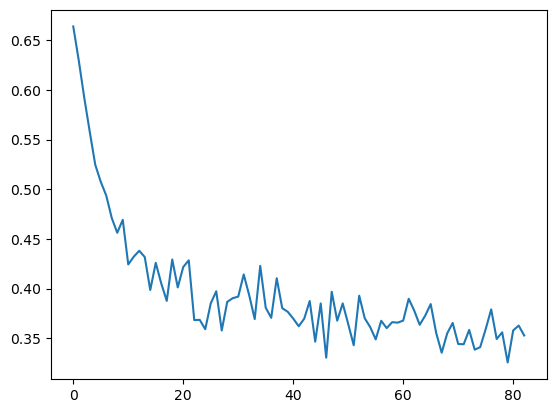

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


/var/folders/ch/l3zqfvbx3754m9pz3mkc4qjh0000gn/T/ipykernel_51027/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/ch/l3zqfvbx3754m9pz3mkc4qjh0000gn/T/ipykernel_51027/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


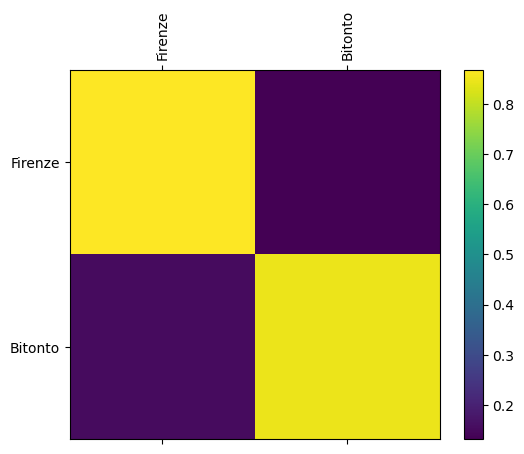

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [31]:
def predict(input_line, n_predictions=1):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

#predict('caputo')
#predict('mele')
#predict('de luca')
#predict('palumbo')
#predict('vendola')
#predict('mirra')
#predict('dilucia')
#predict('giordano')

predict('martelli')
predict('gori')
predict('rossi')
predict('pucci')
predict('pacciani')
predict('renzi')
predict('nardella')
predict('ciacci')
predict('donati')


> martelli
(-0.56) Bitonto

> gori
(-0.05) Firenze

> rossi
(-0.03) Firenze

> pucci
(-0.17) Firenze

> pacciani
(-0.12) Firenze

> renzi
(-0.16) Firenze

> nardella
(-0.07) Bitonto

> ciacci
(-0.25) Firenze

> donati
(-0.26) Firenze
